In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load Dataset

In [4]:
import os
print(os.listdir("C:\\Users\\masud\\Downloads\\Telco Customer churn"))


['.ipynb_checkpoints', 'telco-data-updated.ipynb', 'WA_Fn-UseC_-Telco-Customer-Churn.csv']


In [9]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Drop customerID (not useful for classification)

In [10]:
df.drop(columns=['customerID'], inplace=True)

# Convert TotalCharges to numeric (handle missing values)

In [11]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


C:\Users\masud\AppData\Local\Temp\ipykernel_12176\2576541415.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


# Convert Churn to binary (Yes -> 1, No -> 0)

In [12]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Identify numerical and categorical features

In [13]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# One-hot encode categorical variables

In [14]:
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Split features and target

In [15]:
X = df.drop(columns=['Churn'])
y = df['Churn']


# Train-test-validation split (70%-15%-15%)

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


# Standardize numerical features

In [17]:
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Convert to PyTorch tensors

In [18]:
print(X_train.dtypes[X_train.dtypes == 'object'])


Series([], dtype: object)


In [19]:
# Ensure all categorical variables are one-hot encoded
X = pd.get_dummies(X, drop_first=True)

# Convert all columns to numeric (handles any unexpected non-numeric data)
X = X.apply(pd.to_numeric, errors='coerce')

# Fill NaNs with 0 (or consider filling with column mean)
X.fillna(0, inplace=True)

# Re-split the dataset after fixing data issues
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Ensure all numerical columns are standardized
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


In [20]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoaders

In [21]:
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

# Define improved neural network

In [22]:
class ChurnClassifier(nn.Module):
    def __init__(self, input_size):
        super(ChurnClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.4),

            nn.Linear(64, 32),
            nn.LeakyReLU(),

            nn.Linear(32, 16),
            nn.LeakyReLU(),

            nn.Linear(16, 2)  # Binary classification
        )

    def forward(self, x):
        return self.model(x)

# Initialize model

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChurnClassifier(input_size=X_train.shape[1]).to(device)

# Loss function and optimizer

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Train model

Epoch 1: Train Loss: 0.5049, Train Acc: 0.7379, Val Loss: 0.4541, Val Acc: 0.7936
Epoch 2: Train Loss: 0.4431, Train Acc: 0.7826, Val Loss: 0.4554, Val Acc: 0.7576
Epoch 3: Train Loss: 0.4308, Train Acc: 0.7919, Val Loss: 0.4421, Val Acc: 0.7812
Epoch 4: Train Loss: 0.4301, Train Acc: 0.7970, Val Loss: 0.4336, Val Acc: 0.7888
Epoch 5: Train Loss: 0.4325, Train Acc: 0.7915, Val Loss: 0.4342, Val Acc: 0.7917
Epoch 6: Train Loss: 0.4241, Train Acc: 0.7941, Val Loss: 0.4358, Val Acc: 0.7992
Epoch 7: Train Loss: 0.4205, Train Acc: 0.7949, Val Loss: 0.4426, Val Acc: 0.7794
Epoch 8: Train Loss: 0.4242, Train Acc: 0.8026, Val Loss: 0.4318, Val Acc: 0.7917
Epoch 9: Train Loss: 0.4207, Train Acc: 0.8014, Val Loss: 0.4367, Val Acc: 0.7841
Epoch 10: Train Loss: 0.4160, Train Acc: 0.8043, Val Loss: 0.4308, Val Acc: 0.7898
Epoch 11: Train Loss: 0.4141, Train Acc: 0.8037, Val Loss: 0.4296, Val Acc: 0.7917
Early stopping triggered.


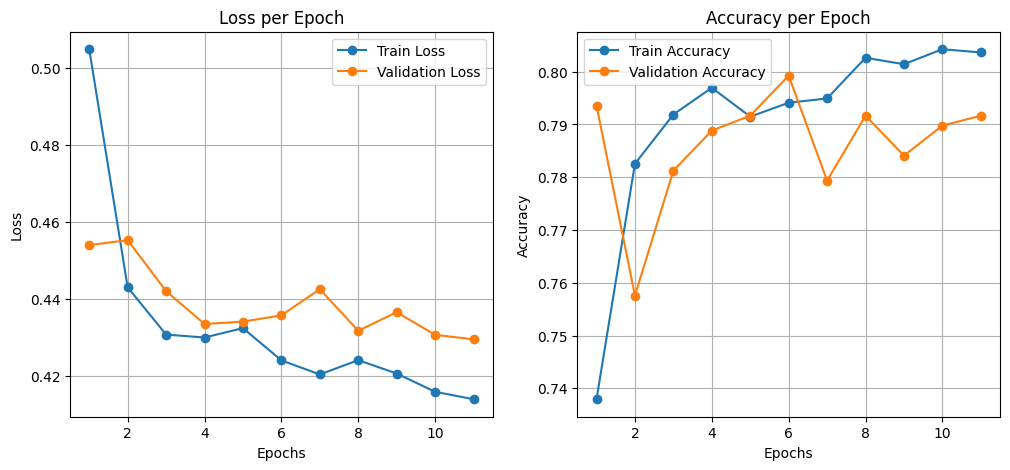

In [25]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50, patience=5):
    best_val_acc = 0.0
    patience_counter = 0

    # ✅ Initialize lists for tracking metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)

        train_acc = correct_train / total_train
        train_loss /= len(train_loader)

        # ✅ Append values for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == y_batch).sum().item()
                total_val += y_batch.size(0)

        val_acc = correct_val / total_val
        val_loss /= len(val_loader)

        # ✅ Append values for plotting
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step(val_loss)  # Adjust learning rate

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Load best model state
    model.load_state_dict(best_model_state)

    # ✅ Plot Loss & Accuracy Curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Epoch")
    plt.legend()
    plt.grid()

    plt.show()

# Call the function
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)


# Evaluate on test set

In [26]:
model.eval()
test_loss, correct_test, total_test = 0, 0, 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == y_batch).sum().item()
        total_test += y_batch.size(0)

test_acc = correct_test / total_test
test_loss /= len(test_loader)

print(f"\nFinal Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_acc:.4f}")


Final Test Loss: 0.4242, Final Test Accuracy: 0.8051
